**<h2>Code to extract data by polygon in Google Earth Engine**
**<h4>César Iván Álvarez**
**<h5>Geospatial Data Scientist**

**<h2>Installing, loading and credential of libraries<h2>**

In [1]:
 #Instalación de bibliotecas necesarias
!pip install geopandas rasterio geemap PyCRS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32688 sha256=1ee467d208802b08951654504c0554b864adde93ca262abb538616cbd9a6d3e0
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built PyCRS


In [9]:
#GEE Libraries - Installing using Conda
import ee #GEE library
# Trigger the authentication flow.
ee.Authenticate()

True

In [6]:
from google.colab import drive #Mount Google Drive in your colab
drive.mount('/content/drive')

Mounted at /content/drive


**<h2>Import Libraries<h2>**

In [11]:
import geopandas as gpd
import geemap
#import rasterio
#from rasterio.mask import mask
import numpy as np
import pandas as pd
import os
import pycrs

ee.Initialize(project='cesarivan') #GEE initialization selecting the addecuate project according to your GEE account


**<h2>Define Input Parameters (Dates and attribute to filter areas)<h2>**

In [12]:
# Shapefile URL
area = '/content/drive/My Drive/CesarIvan/ICARDA/01_SHAPEFILES/SENEGAL_REGIONS/SENEGAL_REGIONS_TEST.shp' #here, we will modify the study area (polygon shapefile)
#area = '/content/drive/My Drive/CesarIvan/ICARDA/01_SHAPEFILES/SENEGAL_REGIONS/SENEGAL_REGIONS.shp'

# Load the polygon shapefile
shape = gpd.read_file(area)
AOI_total = geemap.shp_to_ee(area)

#Name of the attribute field to filter
selection = 'NOM'

**<h2>Dataset construction from GEE extraction by polygon<h2>**

In [13]:
attable = pd.DataFrame(shape,columns=[selection])
columns = ["Area", "Year", "NDVI", "LST (°C)","Mean Temperature (°C)", "MAX Temperature (°C)", "Min Temperature (°C)", "Precipitation (mm)"]
rstable= pd.DataFrame()
scale=30000

for year in range(2000, 2020):
  modis_ndvi = ee.ImageCollection('MODIS/006/MOD13Q1') \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filterBounds(AOI_total) \
            .select('NDVI')

  modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filterBounds(AOI_total) \
            .select('LST_Day_1km')

  era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')\
            .filterDate(f'{year}-01-01', f'{year}-12-31')\
            .filterBounds(AOI_total)

  i = 0

  for i in range(len(attable.index)):
      namarea = attable.iloc[i,0]
      AOI = AOI_total.filter(ee.Filter.eq(selection, namarea))
      ndvi_modis = modis_ndvi.median().clip(AOI).multiply(0.0001)
      lst_modis = modis_lst.median().clip(AOI).multiply(0.02).subtract(273.15)
      temp_med_era5 = era5_2mt.median().select('mean_2m_air_temperature').clip(AOI).subtract(273.15)
      temp_max_era5 = era5_2mt.median().select('maximum_2m_air_temperature').clip(AOI).subtract(273.15)
      temp_min_era5 = era5_2mt.median().select('minimum_2m_air_temperature').clip(AOI).subtract(273.15)
      prec_era5 = era5_2mt.median().select('total_precipitation').clip(AOI).multiply(1000)


      stats_ndvi = ndvi_modis.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry= AOI.geometry(),
        scale = scale,
        maxPixels = 1e13
        )
      stats_ndvi = stats_ndvi.get('NDVI').getInfo()

      stats_lst = lst_modis.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry= AOI.geometry(),
        scale = scale,
        maxPixels = 1e13
        )
      stats_lst = stats_lst.get('LST_Day_1km').getInfo()

      statstempmed = temp_med_era5.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry= AOI.geometry(),
        scale = scale,
        maxPixels = 1e13
        )
      statstempmed = statstempmed.get('mean_2m_air_temperature').getInfo()

      statstempmax = temp_max_era5.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry= AOI.geometry(),
        scale = scale,
        maxPixels = 1e13
        )
      statstempmax = statstempmax.get('maximum_2m_air_temperature').getInfo()

      statstempmin = temp_min_era5.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry= AOI.geometry(),
        scale = scale,
        maxPixels = 1e13
        )
      statstempmin = statstempmin.get('minimum_2m_air_temperature').getInfo()

      statsprec = prec_era5.reduceRegion(
        reducer = ee.Reducer.median(),
        geometry= AOI.geometry(),
        scale = scale,
        maxPixels = 1e13
        )
      statsprec = statsprec.get('total_precipitation').getInfo()

      data = [columns, [namarea, year, stats_ndvi, stats_lst, statstempmed, statstempmax, statstempmin, statsprec] ]
      column_names = data.pop(0)
      df = pd.DataFrame(data, columns=column_names)
      rstable = pd.concat([rstable,df], axis=0, ignore_index=True)
      #rstable = rstable.append(df)

rstable

,Area,Year,NDVI,LST (°C),Mean Temperature (°C),MAX Temperature (°C),Min Temperature (°C),Precipitation (mm)
0,AREA1,2000,0.23545,35.542000,23.929865,24.967706,22.567987,0.009946
1,AREA2,2000,0.24430,37.590000,26.815668,33.804376,20.926843,0.003063
2,AREA1,2001,0.23330,36.350000,24.815393,25.546625,24.198083,0.011649
3,AREA2,2001,0.26330,38.610000,27.266351,34.376886,21.497766,0.008603
4,AREA1,2002,0.23290,34.930000,23.759332,24.607080,23.163904,0.003723
5,AREA2,2002,0.23310,38.270000,26.808618,33.783533,21.150568,0.011374
6,AREA1,2003,0.21070,34.110000,23.562341,24.346277,23.065149,0.011404
7,AREA2,2003,0.21810,36.382000,26.763788,33.725061,20.878809,0.029279
8,AREA1,2004,0.21390,35.450667,23.616144,24.243677,23.078577,0.003237
9,AREA2,2004,0.25220,37.763333,27.070703,33.933130,20.907922,0.001647


**<h2>Time Series and Correlation Graphs<h2>**

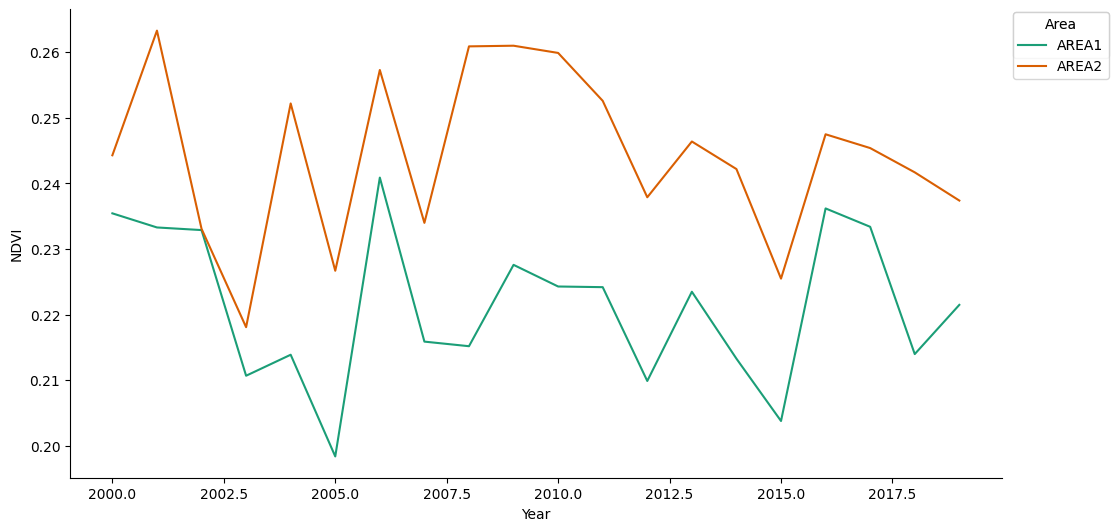

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['NDVI']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rstable.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Area')):
  _plot_series(series, series_name, i)
  fig.legend(title='Area', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('NDVI')

**<h2>Map visualization<h2>**

<ipython-input-15-8aebbd451ece>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_mat = rstable.corr()


<Axes: >

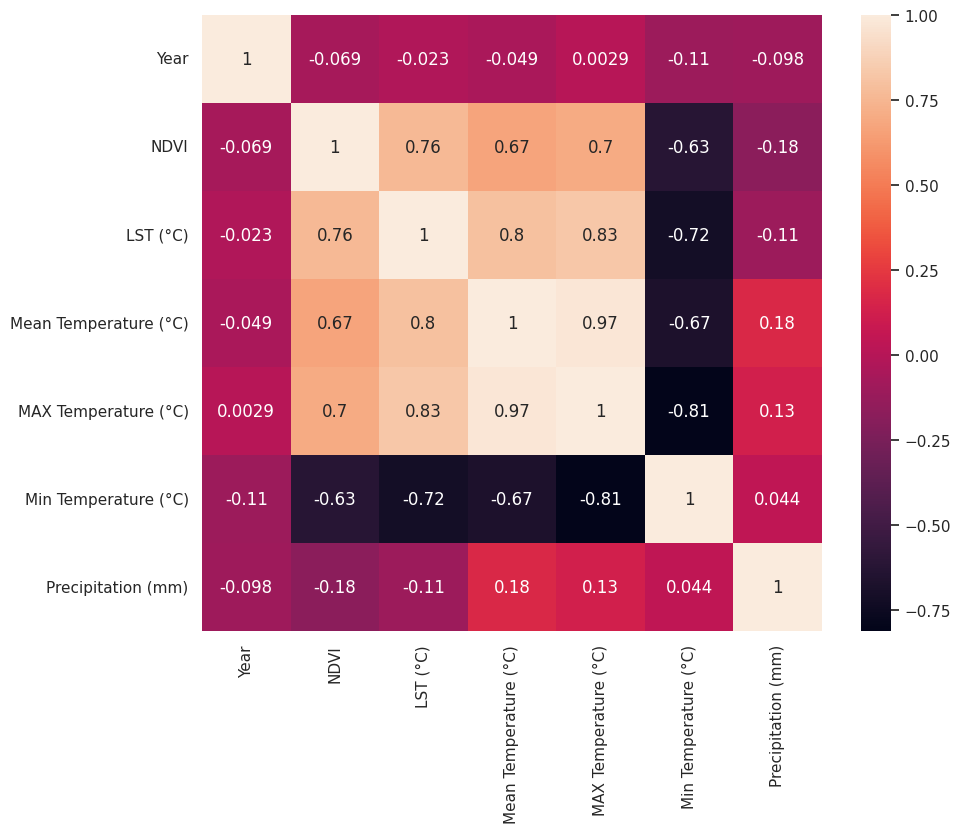

In [15]:
import seaborn as sns

# plot a heatmap with annotation
correlation_mat = rstable.corr()
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(correlation_mat, annot = True)


In [16]:
Map = geemap.Map()
Map.centerObject(AOI_total, 7)

visParams = {'color': 'blue'}
Map.addLayer(AOI_total, visParams,'Study Area')

palette = ['ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301']
ndviVis = {'min':-1, 'max':1, 'palette': palette }

Map.addLayer(ndvi_modis, ndviVis, 'MODIS NDVI')



tempcol = ['000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff']
temperature = {'min': 0, 'max': 40, 'palette': tempcol }

era5 = era5_2mt.median().select('mean_2m_air_temperature').clip(AOI_total).subtract(273.15)
Map.addLayer(era5, temperature, 'Mean Air Temperature')

Map


Map(center=[14.93386766847554, -16.48347153386409], controls=(WidgetControl(options=['position', 'transparent_…